#**Text Analysis on Restaurants Reviews posted on TripAdvisor:**

Continuing from the previous part, we will work on this NLP project for Text Analysis to predict Sentiment. We will conduct Topic Analysis to associate Topics with Keywords from the Corpus. Then, we will use classifiers to Predict the Sentiment on from the modelled Topics.

To work on Topic Modelling from the reviews on the restaurants, we will preprocess our tokens to use Genism and Spacy. These two has a powerful features to model the data and infer the information for topic modelling, especially considering Lemmatization, Stopwords and POS tagging.

We will follow the LDA approach to model the possible topics.

Due to logistic constraints, we will free the occupied memory to run our analysis time by time. And also we will consider to take a representative sample from the large dataset.

Clear Memory to start fresh:

In [1]:
%reset -f

In [2]:
import gc
gc.collect()

9

Import Libraries:

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Recall the clean, tokenized dataframe:

In [5]:
newyork = pd.read_csv('gdrive/My Drive/Colab Notebooks/TripAdvisor Review NLP Analysis/data/newyork.csv', index_col=False)

In [6]:
newyork.head()

,restaurant_name,rating_review,sample,review_full,text,tokenized,Word_count
0,Lido,5,Positive,My wife and I have been eating dinner frequent...,wife eat dinner frequently lido virtually sinc...,"['wife', 'eat', 'dinner', 'frequently', 'lido'...",84
1,Lido,4,Positive,Came with family for Labor Day weekend brunch ...,come family labor day weekend brunch daughter ...,"['come', 'family', 'labor', 'day', 'weekend', ...",64
2,Lido,1,Negative,Food was mediocre at best. The lamb chops are ...,food mediocre best lamb chop image feature web...,"['food', 'mediocre', 'best', 'lamb', 'chop', '...",63
3,Lido,5,Positive,My co-workers were volunteering at a foodbank ...,co worker volunteer foodbank around corner com...,"['co', 'worker', 'volunteer', 'foodbank', 'aro...",52
4,Lido,5,Positive,Lido is an intimate boutique style restaurant....,lido intimate boutique style restaurant servin...,"['lido', 'intimate', 'boutique', 'style', 'res...",30


In this part, we will emphesize on using Spacy and Genism Libraries to preprocess for modelling.

In [7]:
! pip install spacy

In [8]:
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# Import NLTK
import nltk
nltk.download('stopwords')

# Import Spacy
import spacy

# Import Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We will use NLTK stopwords corpus, modifying it to minimize the bias for further analysis.

In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['food', 'place', 'restaurant', 'go','u'])

In [11]:
newyork.head()

,restaurant_name,rating_review,sample,review_full,text,tokenized,Word_count
0,Lido,5,Positive,My wife and I have been eating dinner frequent...,wife eat dinner frequently lido virtually sinc...,"['wife', 'eat', 'dinner', 'frequently', 'lido'...",84
1,Lido,4,Positive,Came with family for Labor Day weekend brunch ...,come family labor day weekend brunch daughter ...,"['come', 'family', 'labor', 'day', 'weekend', ...",64
2,Lido,1,Negative,Food was mediocre at best. The lamb chops are ...,food mediocre best lamb chop image feature web...,"['food', 'mediocre', 'best', 'lamb', 'chop', '...",63
3,Lido,5,Positive,My co-workers were volunteering at a foodbank ...,co worker volunteer foodbank around corner com...,"['co', 'worker', 'volunteer', 'foodbank', 'aro...",52
4,Lido,5,Positive,Lido is an intimate boutique style restaurant....,lido intimate boutique style restaurant servin...,"['lido', 'intimate', 'boutique', 'style', 'res...",30


In [12]:
newyork['text'].head()

,text
0,wife eat dinner frequently lido virtually sinc...
1,come family labor day weekend brunch daughter ...
2,food mediocre best lamb chop image feature web...
3,co worker volunteer foodbank around corner com...
4,lido intimate boutique style restaurant servin...


Due to logistic constraint, we will consider a sample of 20000 rows from the 'newyork' dataframe to fit our model. We will take equal number of samples from both positive and negative reviews to keep control on bias/ avoid overfitting of the model.

In [13]:
sample_df = newyork.groupby('sample').sample(n=10000, random_state=12)
df = sample_df['text']

df.head()

,text
227450,sometimes place visit staff seem really grumpy...
350576,9 25 2010 6 u go puglia dessert drink san gerr...
371730,atmosphere nice alert1 careful waiter select l...
476348,go 2 4pm sunday especially pretty view mediocr...
370448,arrive 7pm 45 minute wait table problem popula...


Lets start processing our text to get it ready to fit our model:

Tokenize words and Clean-up text

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True, removes punctuations

data_words = list(sent_to_words(df))

print(data_words[:1])

[['sometimes', 'place', 'visit', 'staff', 'seem', 'really', 'grumpy', 'unpleasant', 'find', 'high', 'unusual', 'nyc', 'find', 'one', 'find', 'great', 'experience', 'tell', 'people', 'terrible', 'experience', 'publish', 'internet', 'book', 'window', 'table', 'pm', 'slot', 'sunday', 'open', 'table', 'issue', 'probably', 'recommend', 'thrive', 'saturday', 'night', 'bar', 'one', 'floor', 'good', 'view', 'yes', 'get', 'table', 'seat', 'genuinely', 'want', 'hour', 'say', 'take', 'picture', 'get', 'drink', 'beer', 'per', 'head', 'average', 'nyc', 'server', 'snap', 'take', 'photos', 'threw', 'bill', 'table', 'finish', 'drink', 'grumpy', 'moody', 'advice', 'find', 'good', 'street', 'bar']]


Creating Bigram and Trigram Models

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)  # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)                   # we will be avoiding working out with Trigrams due to low memory capacity & performance issue.

# See trigram example
print(bigram_mod[data_words[0]])

['sometimes', 'place', 'visit', 'staff', 'seem', 'really', 'grumpy', 'unpleasant', 'find', 'high', 'unusual', 'nyc', 'find', 'one', 'find', 'great', 'experience', 'tell', 'people', 'terrible', 'experience', 'publish', 'internet', 'book', 'window', 'table', 'pm', 'slot', 'sunday', 'open', 'table', 'issue', 'probably', 'recommend', 'thrive', 'saturday', 'night', 'bar', 'one', 'floor', 'good', 'view', 'yes', 'get', 'table', 'seat', 'genuinely', 'want', 'hour', 'say', 'take', 'picture', 'get', 'drink', 'beer', 'per', 'head', 'average', 'nyc', 'server', 'snap', 'take', 'photos', 'threw', 'bill', 'table', 'finish', 'drink', 'grumpy', 'moody', 'advice', 'find', 'good', 'street', 'bar']


Remove Stopwords, Make Bigrams and Lemmatize

In [16]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#   return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['sometimes', 'visit', 'staff', 'seem', 'really', 'grumpy', 'unpleasant', 'find', 'high', 'unusual', 'find', 'find', 'great', 'experience', 'tell', 'people', 'terrible', 'experience', 'publish', 'internet', 'book', 'window', 'table', 'pm', 'slot', 'open', 'table', 'issue', 'probably', 'recommend', 'thrive', 'night', 'bar', 'floor', 'good', 'view', 'get', 'table', 'seat', 'genuinely', 'want', 'hour', 'say', 'take', 'picture', 'get', 'drink', 'beer', 'head', 'average', 'server', 'take', 'photo', 'throw', 'bill', 'table', 'finish', 'drink', 'grumpy', 'moody', 'advice', 'find', 'good', 'street', 'bar']]


Create the Dictionary and Corpus needed for Topic Modeling

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out words that occur less than 10 by numbers in the documents, or more than 90% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 4), (9, 1), (10, 1), (11, 1), (12, 2), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 4), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]]


In [20]:
id2word[0]

'advice'

In [21]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advice', 1),
  ('average', 1),
  ('bar', 2),
  ('beer', 1),
  ('bill', 1),
  ('book', 1),
  ('drink', 2),
  ('experience', 2),
  ('find', 4),
  ('finish', 1),
  ('floor', 1),
  ('genuinely', 1),
  ('get', 2),
  ('good', 2),
  ('great', 1),
  ('grumpy', 2),
  ('head', 1),
  ('high', 1),
  ('hour', 1),
  ('internet', 1),
  ('issue', 1),
  ('night', 1),
  ('open', 1),
  ('people', 1),
  ('photo', 1),
  ('picture', 1),
  ('pm', 1),
  ('probably', 1),
  ('really', 1),
  ('recommend', 1),
  ('say', 1),
  ('seat', 1),
  ('seem', 1),
  ('server', 1),
  ('sometimes', 1),
  ('staff', 1),
  ('street', 1),
  ('table', 4),
  ('take', 2),
  ('tell', 1),
  ('terrible', 1),
  ('throw', 1),
  ('unpleasant', 1),
  ('unusual', 1),
  ('view', 1),
  ('visit', 1),
  ('want', 1),
  ('window', 1)]]

#####**Building the Topic Model:**

We Will considet LDA model for Topic building.

Optimal Number of Topics Based on Coherence Score: (Using UMass Measure)

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [25]:
start = 2
limit = 20
step = 2

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

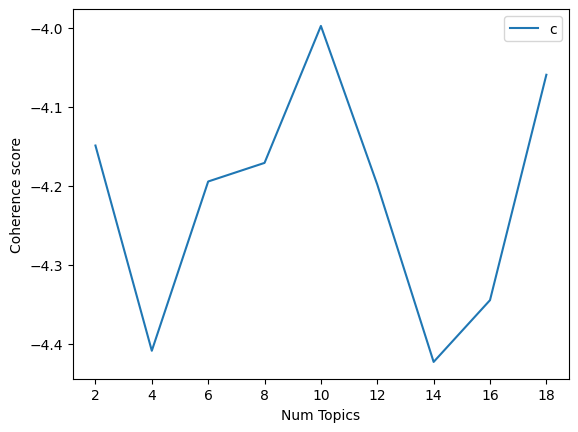

In [26]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -4.1492
Num Topics = 4  has Coherence Value of -4.4087
Num Topics = 6  has Coherence Value of -4.1947
Num Topics = 8  has Coherence Value of -4.1711
Num Topics = 10  has Coherence Value of -3.9979
Num Topics = 12  has Coherence Value of -4.1985
Num Topics = 14  has Coherence Value of -4.4228
Num Topics = 16  has Coherence Value of -4.3447
Num Topics = 18  has Coherence Value of -4.0597


We will consider 6 topics to build the topic model.

Building the LDA Model:

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=34,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

View the topics in LDA model

In [29]:
# Print the Keyword in the 6 topics
pprint(lda_model.print_topics())

[(0,
  '0.061*"wine" + 0.042*"dish" + 0.035*"fresh" + 0.030*"sauce" + '
  '0.026*"appetizer" + 0.023*"beer" + 0.020*"list" + 0.018*"perfectly" + '
  '0.018*"favorite" + 0.015*"dessert"'),
 (1,
  '0.034*"lunch" + 0.033*"serve" + 0.029*"salad" + 0.028*"small" + '
  '0.027*"portion" + 0.027*"breakfast" + 0.023*"burger" + 0.023*"tasty" + '
  '0.022*"large" + 0.021*"side"'),
 (2,
  '0.061*"good" + 0.044*"great" + 0.037*"service" + 0.017*"visit" + '
  '0.017*"excellent" + 0.016*"staff" + 0.016*"well" + 0.016*"friendly" + '
  '0.016*"nice" + 0.016*"menu"'),
 (3,
  '0.028*"get" + 0.027*"time" + 0.027*"make" + 0.023*"table" + 0.019*"come" + '
  '0.018*"order" + 0.017*"back" + 0.016*"wait" + 0.015*"bar" + 0.014*"drink"'),
 (4,
  '0.124*"pizza" + 0.029*"slice" + 0.027*"far" + 0.026*"season" + '
  '0.025*"salmon" + 0.024*"soup" + 0.020*"unique" + 0.020*"dress" + '
  '0.019*"cake" + 0.016*"homemade"'),
 (5,
  '0.053*"delicious" + 0.037*"italian" + 0.035*"taste" + 0.031*"share" + '
  '0.027*"pasta" 

Compute Model Perplexity and Coherence Score

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score considering U_Mass: ', coherence_lda)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score considering CV: ', coherence_lda)


Perplexity:  -6.95747496461628

Coherence Score considering U_Mass:  -3.0124276099304343

Coherence Score considering CV:  0.39721206067559867


###Topic Analysis for the Model with Optimal Number of Topics:

In [31]:
# choosing optimal model
optimal_num_topics = 6

# choosing number of keyword per model
optimal_keywords = 40

# training LDA model with optimal number of topics
optimal_lda_model = lda_model

In [32]:
# creating dictionary that stores topics and top words
optimal_lda_topics = optimal_lda_model.show_topics(
    num_topics=optimal_num_topics,
    num_words=optimal_keywords,
    formatted=False
)

In [34]:
# displayin topics and top words
for topic_id, topic in optimal_lda_topics:
    words = ', '.join([word[0] for word in topic])
    print(f'Topic {topic_id}: {words}\n')

Topic 0: wine, dish, fresh, sauce, appetizer, beer, list, perfectly, favorite, dessert, glass, authentic, fish, flavor, main, variety, bottle, prepare, start, glad, world, shrimp, sweet, cozy, complimentary, spicy, red, dumple, noisy, roll, meatball, seafood, chef, noodle, starter, rice, extensive, chip, cook, pub

Topic 1: lunch, serve, salad, small, portion, breakfast, burger, tasty, large, side, brunch, cheese, chicken, meat, huge, fry, stop, quick, option, plate, style, size, cook, order, sandwich, home, french, fill, hot, egg, bite, diner, sausage, item, ambiance, beef, grill, generous, accommodate, morning

Topic 2: good, great, service, visit, excellent, staff, well, friendly, nice, menu, really, eat, meal, price, dinner, try, also, atmosphere, enjoy, love, recommend, definitely, experience, little, find, look, wonderful, worth, special, always, choice, perfect, bit, lot, family, steak, much, attentive, feel, many

Topic 3: get, time, make, table, come, order, back, wait, bar, d

#####**EDA on the Topics from the Model:**

We will try to dig down deep to get an idea on the relevancy of the Topics. For that, we will implement some visualization and try to analyze the  the keywords for each topics. The module followed for visualization can be found [here](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#15visualizethetopicskeywords) and [here](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#12.-What-are-the-most-discussed-topics-in-the-documents?).

What is the Dominant topic and its percentage contribution in each document/row:

In [35]:
def format_topics_sentences(ldamodel= None, corpus=corpus, texts= texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                new_topic_df = pd.DataFrame({'Dominant_Topic': [int(topic_num)],
                                'Perc_Contribution': [round(prop_topic,4)],
                                'Topic_Keywords':[topic_keywords]})
                new_topic_df = new_topic_df.reset_index(drop=True)
                sent_topics_df = pd.concat([sent_topics_df,new_topic_df], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts= texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5257,"get, time, make, table, come, order, back, wai...","[sometimes, visit, staff, seem, really, grumpy..."
1,1,3,0.5033,"get, time, make, table, come, order, back, wai...","[drink, festival, first, time, eat, high, hope..."
2,2,3,0.3407,"get, time, make, table, come, order, back, wai...","[atmosphere, nice, alert, careful, waiter, sel..."
3,3,2,0.4504,"good, great, service, visit, excellent, staff,...","[especially, pretty, view, mediocre, variety, ..."
4,4,2,0.3438,"good, great, service, visit, excellent, staff,...","[arrive, minute, wait, table, problem, popular..."
5,5,3,0.3918,"get, time, make, table, come, order, back, wai...","[quick, sandwich, coffee, good, service, quick..."
6,6,2,0.4430,"good, great, service, visit, excellent, staff,...","[eat, dinner, really, get, line, breakfast, th..."
7,7,3,0.4191,"get, time, make, table, come, order, back, wai...","[let, first, state, appear, well, manage, feel..."
8,8,2,0.3146,"good, great, service, visit, excellent, staff,...","[underwhelming, expect, signature, waffle, und..."
9,9,2,0.5415,"good, great, service, visit, excellent, staff,...","[need, know, order, bone_ribeye, way, marbly, ..."


In [36]:
df_dominant_topic['Keywords'].unique()

array(['get, time, make, table, come, order, back, wait, bar, drink',
       'good, great, service, visit, excellent, staff, well, friendly, nice, menu',
       'lunch, serve, salad, small, portion, breakfast, burger, tasty, large, side',
       'wine, dish, fresh, sauce, appetizer, beer, list, perfectly, favorite, dessert'],
      dtype=object)

#####The most representative sentence for each topic:

In [37]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.2972,"wine, dish, fresh, sauce, appetizer, beer, list, perfectly, favorite, dessert","[seat, prompty, appetizer, basil, roll, essentially, summer, roll, basil, instead, peanut, sauce..."
1,1,0.3923,"lunch, serve, salad, small, portion, breakfast, burger, tasty, large, side","[breakfast, helpful, menu, dickelback, order, pickle, shoot, whiskey, brand, dickel, serve, spic..."
2,2,0.6620,"good, great, service, visit, excellent, staff, well, friendly, nice, menu","[beautiful, french, outstanding, decor, beautiful, outdoor, patio, rockefeller_center, rink, lov..."
3,3,0.7936,"get, time, make, table, come, order, back, wait, bar, drink","[night, enter, ask, host, table, face, say, wait, long, tell, problem, wait, minute, give, ticke..."


#####Word Clouds of Top N Keywords for Each Topic:

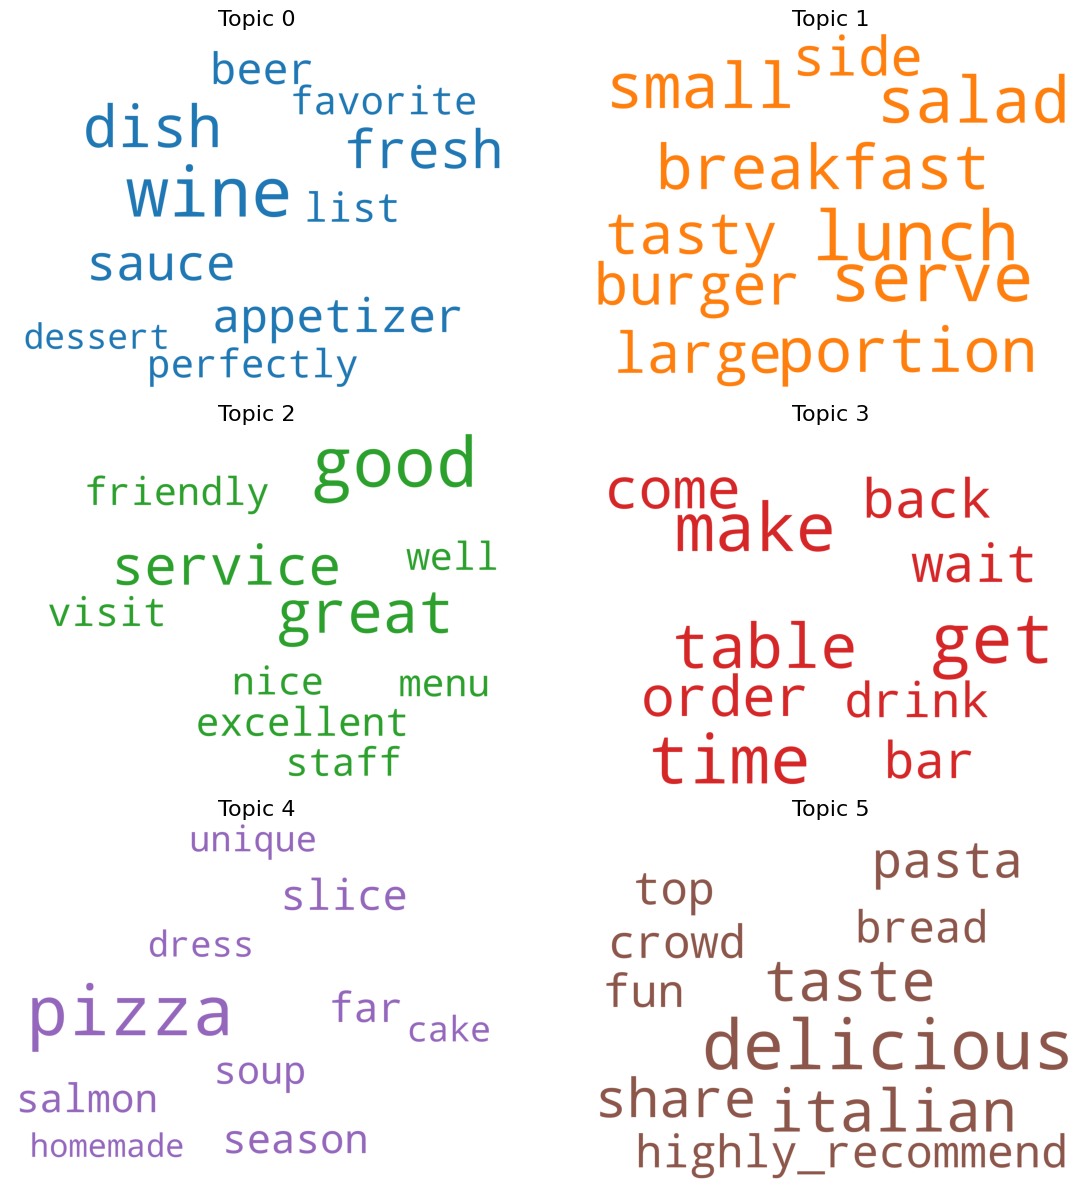

In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3,2 , figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#####Word Counts of Topic Keywords:

<ipython-input-39-dd2c33fb4a30>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


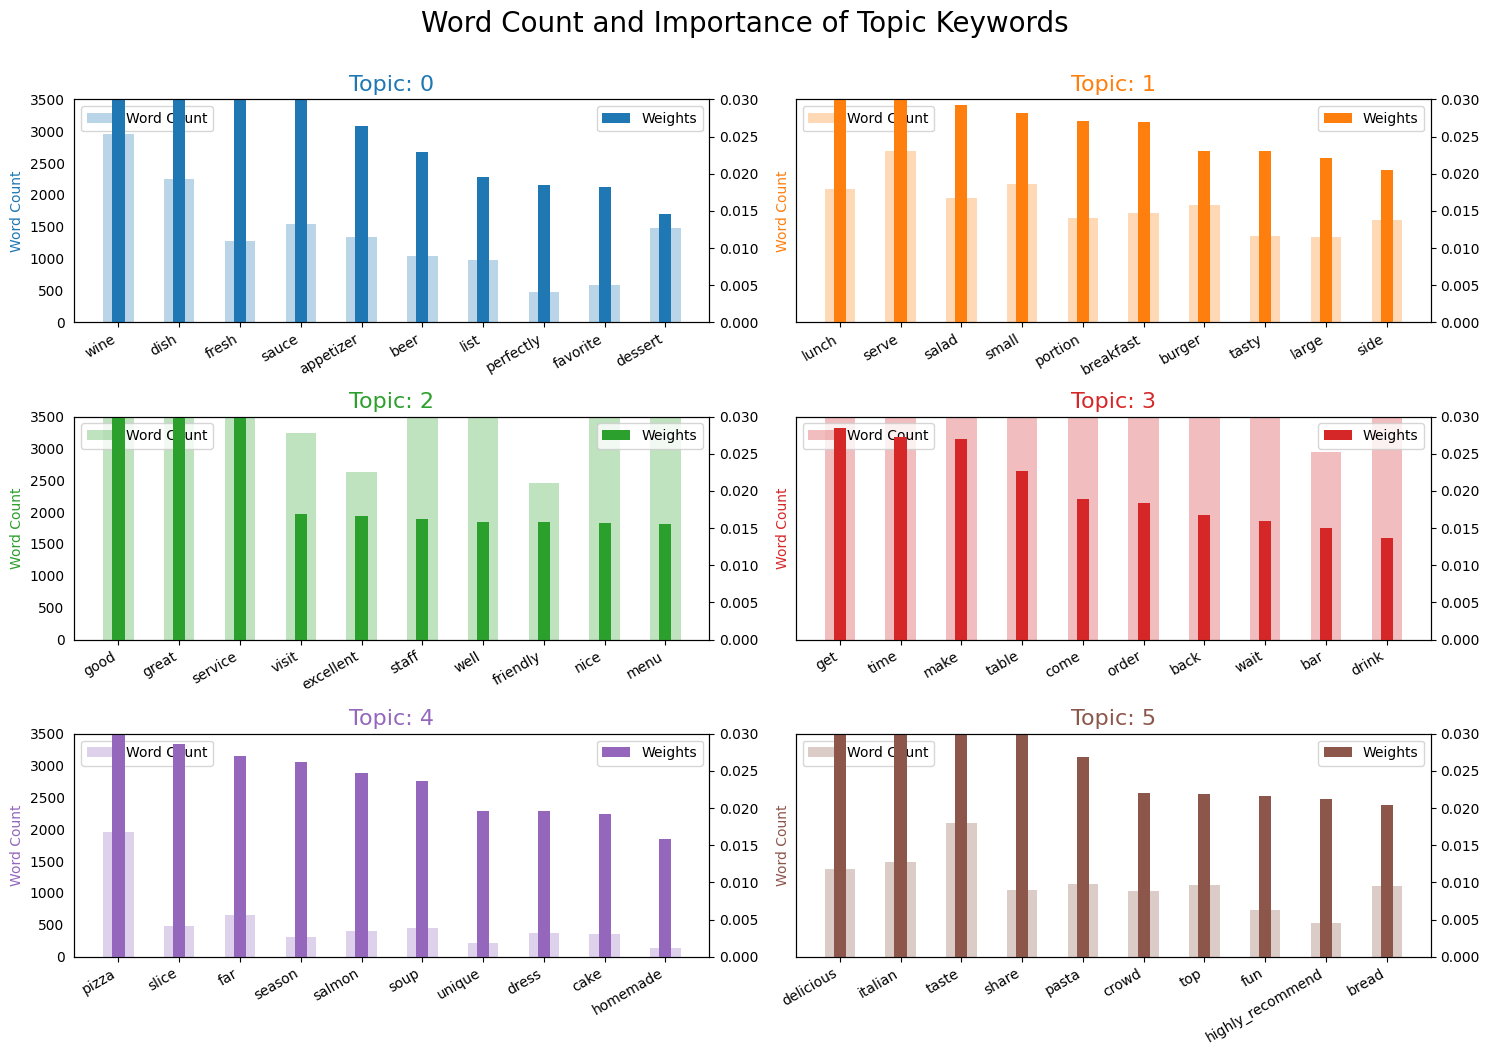

In [39]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(15,10), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=1)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.05)
plt.show()

##### Sparsness of Topic keywords in sentences:

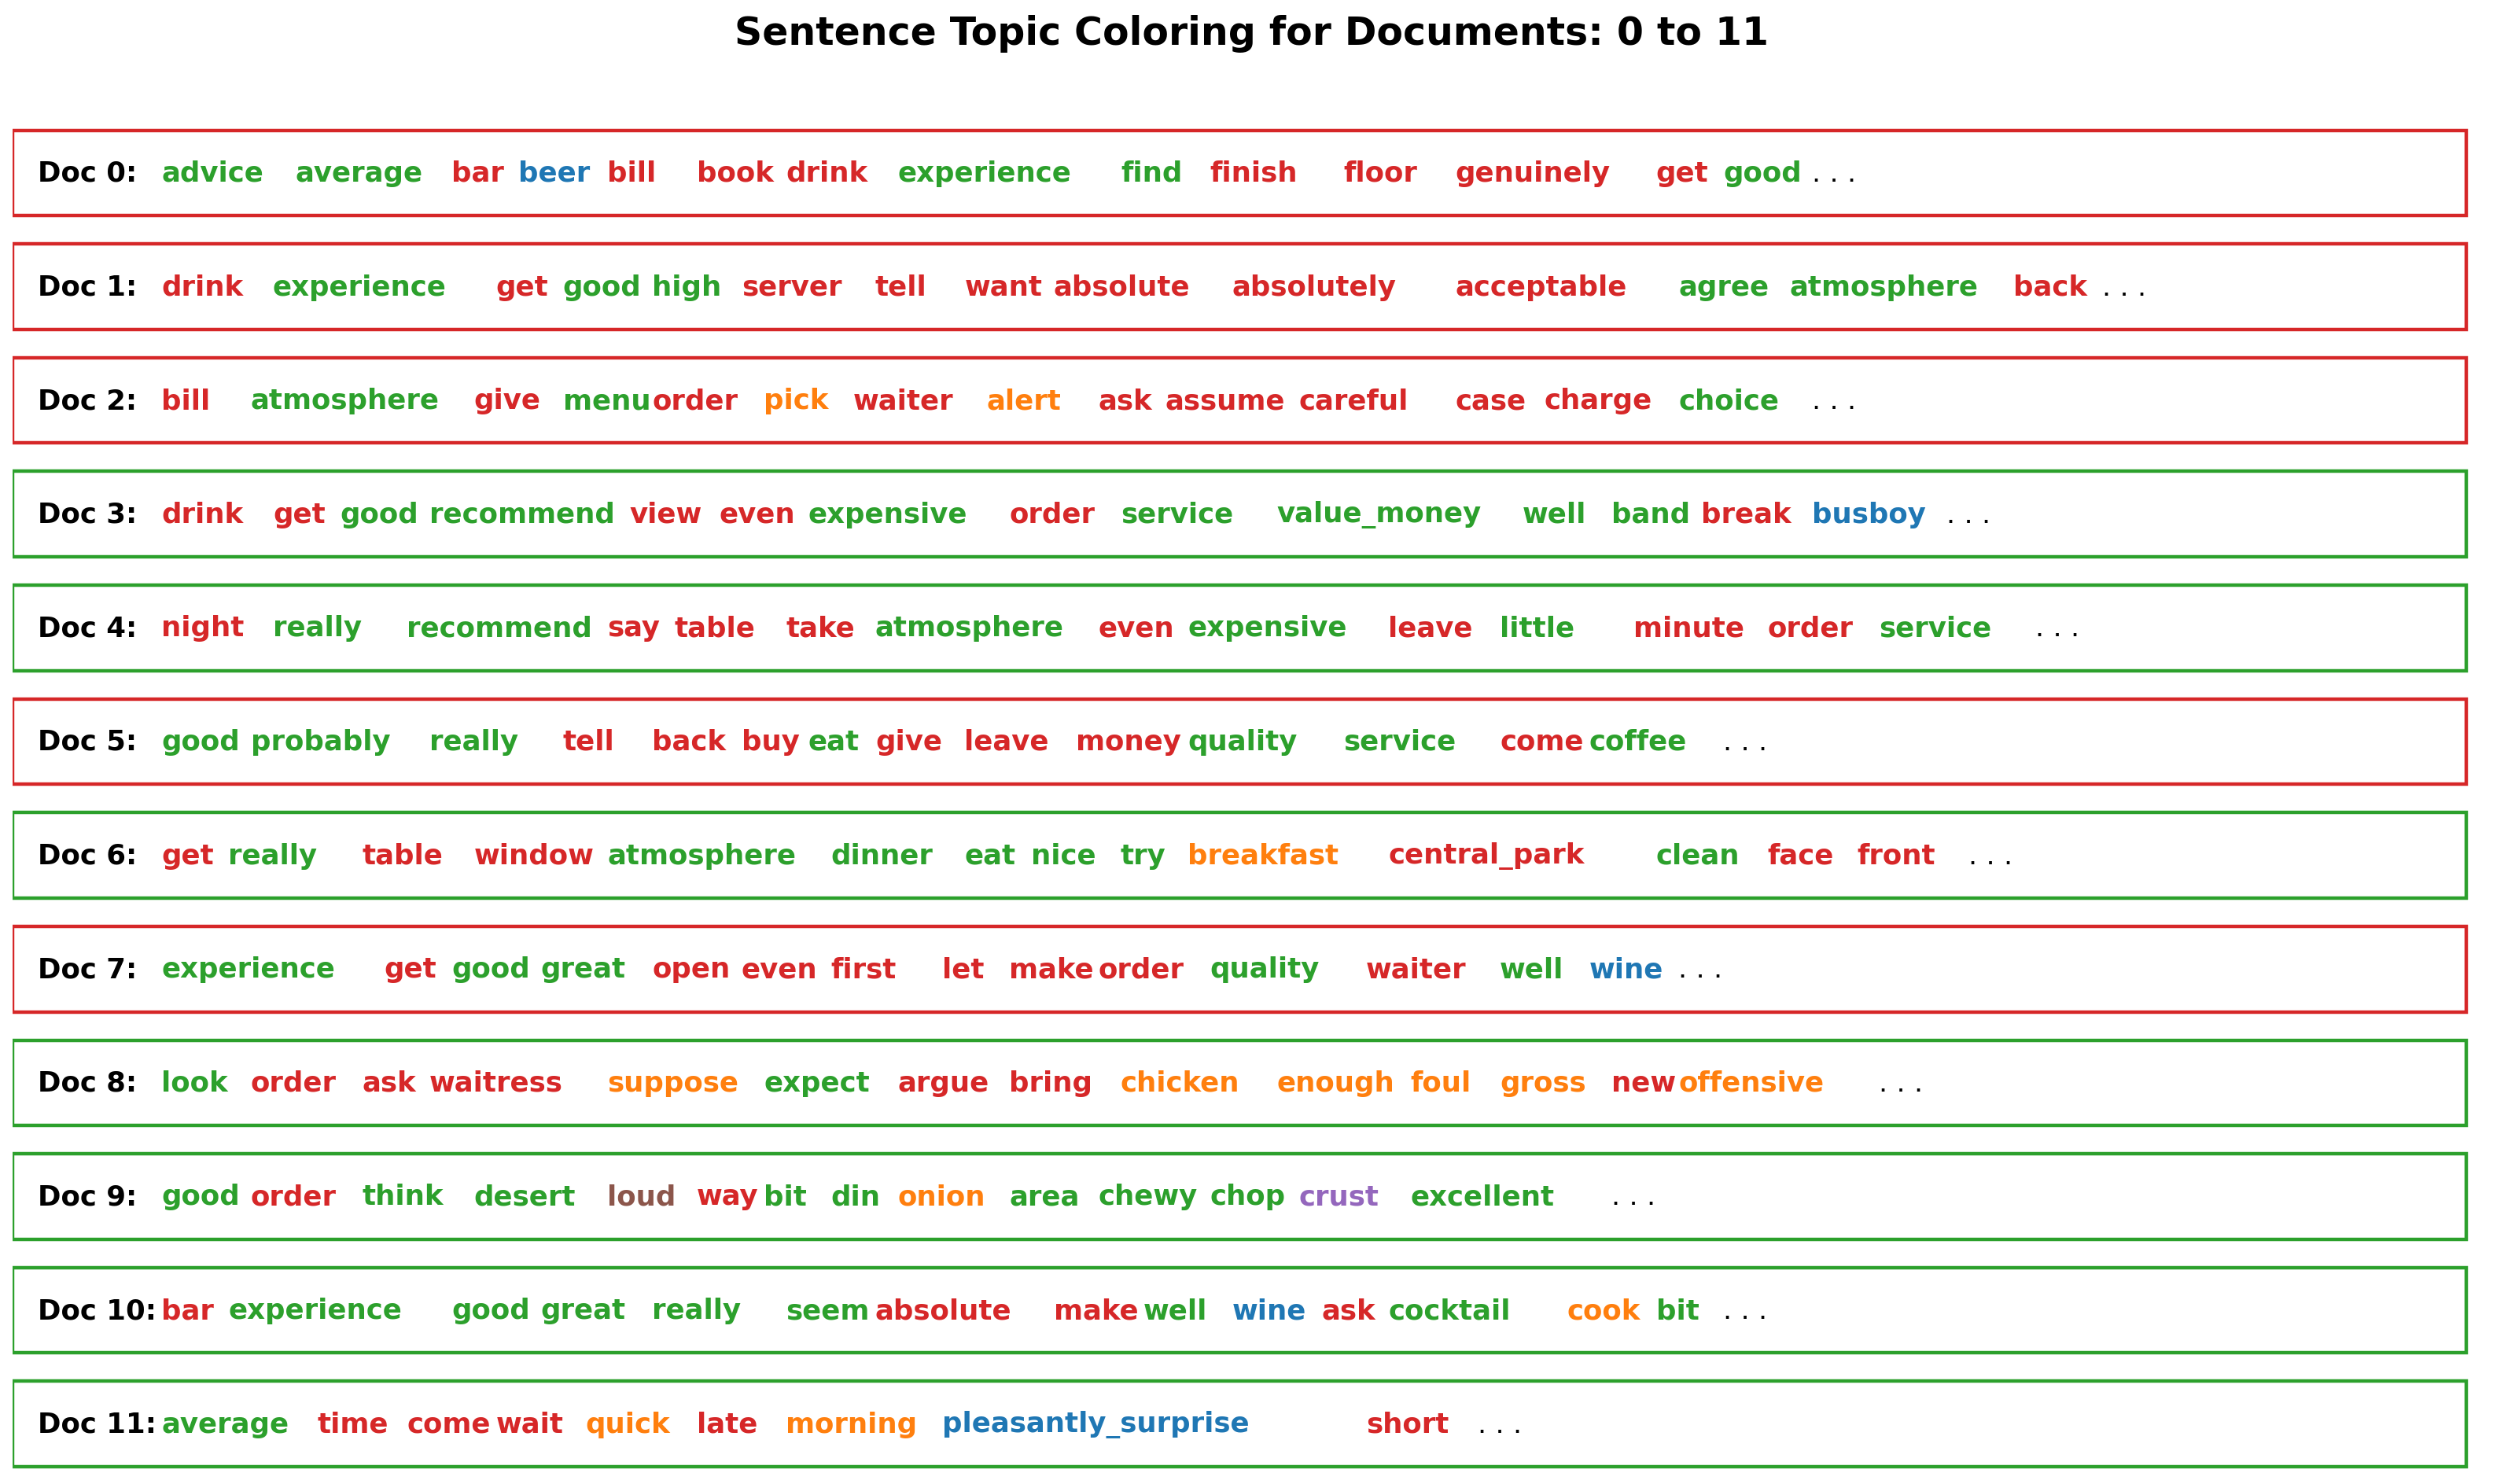

In [40]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [41]:
gc.collect()

36597

####What are the most discussed topics in the documents?

In [42]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

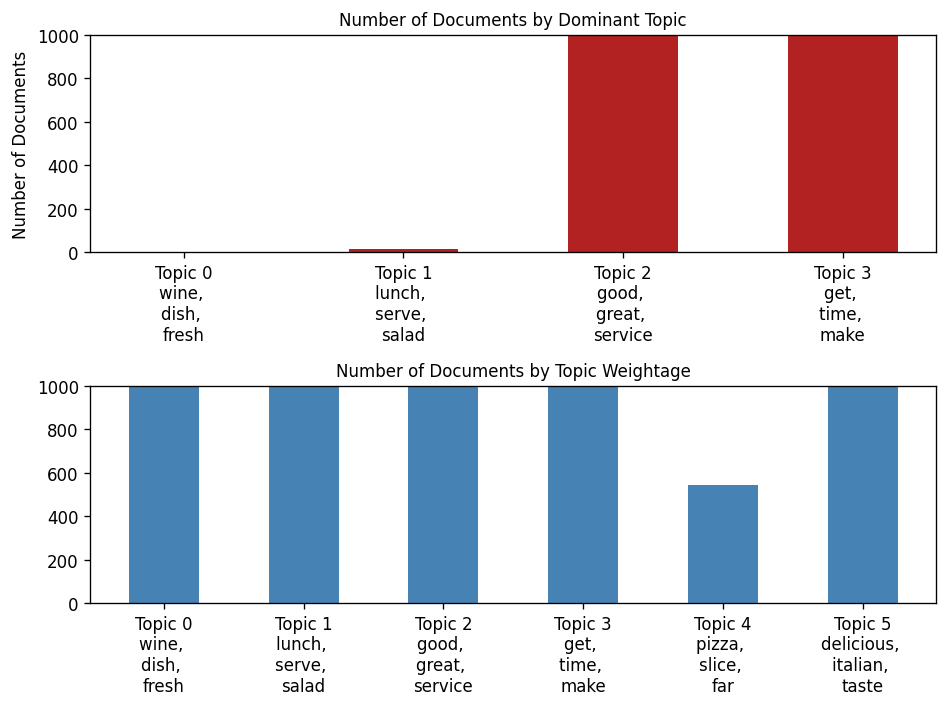

In [43]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.tight_layout()
plt.show()

Observation:

From the graphs and the analysis above, we see that the **'Topic 5'** is the most discussed Dominant Topic in the whole document which is related to **' Quality of Service'**.

The 2nd place for dominant Topic is the '**Topic 3**' which is related to **'Waiting Service'**.

In [ ]:
# Save the Model for Future use

#lda_model.save('lda_model.model')

In [ ]:
# Load the saved LDA model

#lda_model = gensim.models.ldamodel.LdaModel.load("lda_model.model")

####Topic distribution across documents:

In [44]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3,"get, time, make, table, come, order, back, wait, bar, drink",1.0,0.0000
1,3,"get, time, make, table, come, order, back, wait, bar, drink",14.0,0.0007
2,3,"get, time, make, table, come, order, back, wait, bar, drink",15170.0,0.7585
3,2,"good, great, service, visit, excellent, staff, well, friendly, nice, menu",4815.0,0.2408
4,2,"good, great, service, visit, excellent, staff, well, friendly, nice, menu",NaN,NaN
...,...,...,...,...
19995,2,"good, great, service, visit, excellent, staff, well, friendly, nice, menu",NaN,NaN
19996,2,"good, great, service, visit, excellent, staff, well, friendly, nice, menu",NaN,NaN
19997,2,"good, great, service, visit, excellent, staff, well, friendly, nice, menu",NaN,NaN
19998,3,"get, time, make, table, come, order, back, wait, bar, drink",NaN,NaN


In [45]:
list(df_dominant_topics['Topic_Keywords'].unique())

['get, time, make, table, come, order, back, wait, bar, drink',
 'good, great, service, visit, excellent, staff, well, friendly, nice, menu',
 'lunch, serve, salad, small, portion, breakfast, burger, tasty, large, side',
 'wine, dish, fresh, sauce, appetizer, beer, list, perfectly, favorite, dessert']

#Topics for Predicting Sentiment:

Now, we will try different classifiers to Classify the Sentiment (Positive or Negative Review) using the Dominant Topic as Regressors.

In [46]:
df_dominant_topic.reset_index(drop=True, inplace=True)
sample_df.reset_index(drop=True, inplace=True)
finaldf = pd.concat([df_dominant_topic,sample_df],  axis = 1)

In [ ]:
finaldf.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,restaurant_name,rating_review,sample,review_full,text,tokenized,Word_count
0,0,3,0.5257,"get, time, make, table, come, order, back, wait, bar, drink","[sometimes, visit, staff, seem, really, grumpy, unpleasant, find, high, unusual, find, find, gre...",R_Lounge_at_Two_Times_Square,1,Negative,Sometimes there are places that you visit where the staff just seem really grumpy and unpleasant...,sometimes place visit staff seem really grumpy unpleasant find high unusual nyc find one find gr...,"['sometimes', 'place', 'visit', 'staff', 'seem', 'really', 'grumpy', 'unpleasant', 'find', 'high...",159
1,1,3,0.5033,"get, time, make, table, come, order, back, wait, bar, drink","[drink, festival, first, time, eat, high, hope, service, atmosphere, total, let, starter, order,...",Puglia_Restaurant,1,Negative,"On 9/25/2010, 6 of us went to Puglia for dessert and drinks during the San Gerrino festival. It ...",9 25 2010 6 u go puglia dessert drink san gerrino festival first time eat restaurant high hope f...,"['9', '25', '2010', '6', 'u', 'go', 'puglia', 'dessert', 'drink', 'san', 'gerrino', 'festival', ...",301
2,2,3,0.3407,"get, time, make, table, come, order, back, wait, bar, drink","[atmosphere, nice, alert, careful, waiter, select, lunch, set, lunch, give, menu, desert, indepe...",Junoon_Restaurant,1,Negative,atmosphere is very nice. ALERT1:But be careful with the waiters. We selected lunch from the set ...,atmosphere nice alert1 careful waiter select lunch set menu 30 lunch give back menu desert two i...,"['atmosphere', 'nice', 'alert1', 'careful', 'waiter', 'select', 'lunch', 'set', 'menu', '30', 'l...",102
3,3,2,0.4504,"good, great, service, visit, excellent, staff, well, friendly, nice, menu","[especially, pretty, view, mediocre, variety, ok, limit, spectacular, salmon, good, count, secon...",Gallow_Green,3,Negative,We went from 2-4pm on a Sunday. It.s not especially pretty and the view is very mediocre. The va...,go 2 4pm sunday especially pretty view mediocre variety food ok limit nothing spectacular salmon...,"['go', '2', '4pm', 'sunday', 'especially', 'pretty', 'view', 'mediocre', 'variety', 'food', 'ok'...",127
4,4,2,0.3438,"good, great, service, visit, excellent, staff, well, friendly, nice, menu","[arrive, minute, wait, table, problem, popular, fantastic, atmosphere, order, famous, burger, co...",The_Spotted_Pig,3,Negative,"We arrived at 7pm and had a 45 minute wait for a table. No problem with this, it’s popular and h...",arrive 7pm 45 minute wait table problem popular fantastic atmosphere order 3 famous burger cook ...,"['arrive', '7pm', '45', 'minute', 'wait', 'table', 'problem', 'popular', 'fantastic', 'atmospher...",144


In [47]:
finaldf.columns

Index(['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text', 'restaurant_name', 'rating_review', 'sample', 'review_full',
       'text', 'tokenized', 'Word_count'],
      dtype='object')

We will define our classification model such as:

Our Response variable: 'sample' (i.e. positive or negative review).
Our Independent variables: 'Dominant_Topic' and 'Word_count'.

At this point, we can interprete that our Topic Modelling implementation has driven our Unsupervised Modelling to a Supervised one.

In [48]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [49]:
finaldf = pd.get_dummies(finaldf, columns=['sample','Dominant_Topic'])

In [50]:
list(finaldf.columns)

['Document_No',
 'Topic_Perc_Contrib',
 'Keywords',
 'Text',
 'restaurant_name',
 'rating_review',
 'review_full',
 'text',
 'tokenized',
 'Word_count',
 'sample_Negative',
 'sample_Positive',
 'Dominant_Topic_0',
 'Dominant_Topic_1',
 'Dominant_Topic_2',
 'Dominant_Topic_3']

###Classification of Sentiment for Different Classifiers uing **Topics as Regressors**:

Train- Test Split:

In [51]:
X= finaldf[['Dominant_Topic_0','Dominant_Topic_1','Dominant_Topic_2','Dominant_Topic_3','Word_count']]

In [52]:
y = finaldf['sample_Positive']

In [53]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.80,random_state = 42)

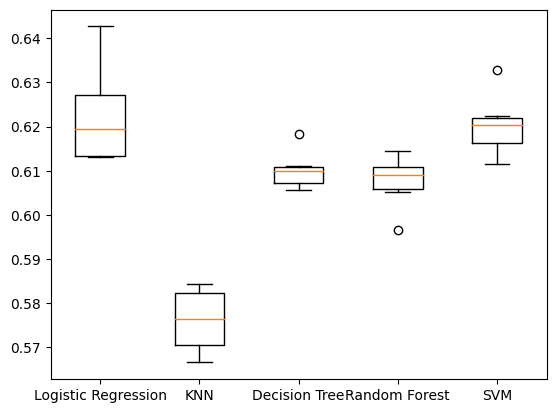

In [54]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {"Logistic Regression": LogisticRegression(solver = 'newton-cg', max_iter = 500, C = 1000),
          "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "SVM": SVC(gamma='auto')
          }

results = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, Xtrain, ytrain, cv=kf)
    results.append(cv_results)


plt.boxplot(results, labels= models.keys())
plt.show()

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for name, model in models.items():
    model.fit(Xtrain, ytrain)
    test_score = model.score(Xtest, ytest)
    prediction = model.predict(Xtest)
    report = classification_report(prediction, ytest)
    mat = confusion_matrix(prediction, ytest)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} Confusion Matrix:\n{}".format(name, mat))
    print("{} Classification Report:\n{}".format(name, report))

Logistic Regression Test Set Accuracy: 0.6225
Logistic Regression Confusion Matrix:
[[ 880  371]
 [1139 1610]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.44      0.70      0.54      1251
        True       0.81      0.59      0.68      2749

    accuracy                           0.62      4000
   macro avg       0.62      0.64      0.61      4000
weighted avg       0.69      0.62      0.64      4000

KNN Test Set Accuracy: 0.57675
KNN Confusion Matrix:
[[1195  869]
 [ 824 1112]]
KNN Classification Report:
              precision    recall  f1-score   support

       False       0.59      0.58      0.59      2064
        True       0.56      0.57      0.57      1936

    accuracy                           0.58      4000
   macro avg       0.58      0.58      0.58      4000
weighted avg       0.58      0.58      0.58      4000

Decision Tree Test Set Accuracy: 0.62125
Decision Tree Confusion Matrix:
[[1004  500]

Obeservation:

From the Box plot above, we notice that the Logistic Regression classifier performs well in terms of accuracy and sparsness.

But, our business interest of this analysis would be on Precision and/or Recall. In that case,

From the Analysis above, the observation that I would like to emphasis on is-
* The preprocessing of the document is an essential part in Topic analysis .
* The importance of mutually exclusive keywords from per Topic is very important (avoid overlapping of keywords)
* Finding the right number of optimum topics should be considered with care.




For this binary-classification Sentiment Analysis, our variable of interest is Positive Review (i.e. 1 if the Review is Positive, 0 elsewise). In this context, the Precision index can be explained as -

$$ Precision = \frac{\text{True Positive}} {\text{True Positive + False Positive}}\
\\= \frac{\text{Customers were happy and gave positive reviews}}{\text{Customers were happy and gave positive reviews + Customers were expected to give positive review but posted negative reviews}} $$


From that point of view, Logistic Regression Classifier is again the best performer.

###Important factors for Positive Reviews in Sentiment Analysis:

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

rf = RandomForestRegressor(n_estimators=150)
rf.fit(Xtrain, ytrain)

RandomForestRegressor(n_estimators=150)

<Axes: >

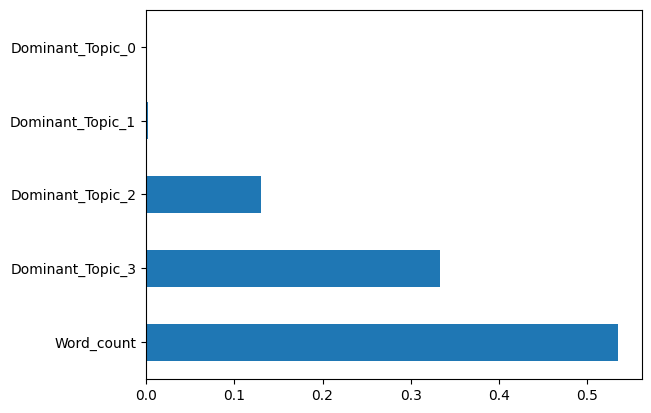

In [57]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=Xtrain.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot(kind='barh')
# feature_importances.plot.bar();

Observation:

We see that, wordcount contributes most for classifying reviews. Also, from this analysis, we find that Dominant topic 5 and Dominant topic 3 are the significant contributors for Positive Reviews.

For Scope for further Analysis with larger scope of Logistic support:

* Considering the whole Dataset for New York.
* Implementing Topic Analysis based Sentiment Classification for 6621 restaurants in New York.
* Consider the Trigram model.
* Implementing Hyperparameter tuning to find optimal number of Topics.
* Defining a pipeline to consider preprocessing, modelling and predicting Sentiment for different documents/ posted reviews.



In [58]:
import statsmodels.api as stat

logit_model=stat.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary())

         Current function value: 0.646172
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        sample_Positive   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19995
Method:                           MLE   Df Model:                            4
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:                 0.06777
Time:                        00:28:02   Log-Likelihood:                -12923.
converged:                      False   LL-Null:                       -13863.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Dominant_Topic_0   -20.8086   5.22e+04     -0.000      1.000   -1.02e+05    1.02e+05
Dominant_Topic_1     0.5875      0.538      1.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




---



---

